# 🎯 Safety Scoring System: 0-100 Neighborhood Rankings

## 🎯 Business Problem

**Challenge**: Crime per capita is ONE number, but safety is multi-dimensional.

**Questions investors ask**:
- Is crime rate low? (Volume)
- Are crimes severe? (Severity) 
- Is it getting better or worse? (Trend)
- Is crime concentrated or spread out? (Distribution)

**Solution**: Comprehensive 0-100 safety score combining all factors.

---

## 📊 Scoring Methodology

### Weighted Components (40-30-20-10 Rule)

1. **Crime Rate (40%)** - Volume of crime per capita
2. **Crime Severity (30%)** - Average seriousness of crimes
3. **Crime Trend (20%)** - Direction over time (2015→2024)
4. **Crime Distribution (10%)** - Concentration across neighborhoods

**Total: 100 points**

---

## 📚 Step 1: Import Libraries

In [31]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import variation

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## 🗄️ Step 2: Load Crime Data from Database

In [32]:
# Connect to database
DB_PATH = "../database/berlin_intelligence.db"
conn = sqlite3.connect(DB_PATH)

# Load complete crime dataset
query = """
SELECT 
    c.*,
    p.total_population
FROM crime_statistics c
LEFT JOIN district_population p ON c.district_id = p.district_id
WHERE p.total_population IS NOT NULL
"""

df_crime = pd.read_sql_query(query, conn)
conn.close()

print(f"✅ Loaded {len(df_crime):,} crime records")
print(f"📊 Districts: {df_crime['district'].nunique()}")
print(f"📊 Years: {df_crime['year'].min()} - {df_crime['year'].max()}")
print(f"📊 Crime types: {df_crime['crime_type_english'].nunique()}")

df_crime.head()

✅ Loaded 28,390 crime records
📊 Districts: 12
📊 Years: 2015 - 2024
📊 Crime types: 17


,area_id,neighborhood,district,district_id,year,crime_type_german,crime_type_english,category,total_number_cases,frequency_100k,population_base,severity_weight,total_population
0,13007.0,Osloer Straße,Mitte,01,2015,Brand- stiftung,Arson,Property Crime,13.0,34.0,None,4.5,397004
1,13007.0,Osloer Straße,Mitte,01,2015,Branddelikte -insgesamt-,Arson Total,Property Crime,35.0,92.0,None,4.0,397004
2,13007.0,Osloer Straße,Mitte,01,2015,Diebstahl -insgesamt-,Theft Total,Property Crime,3623.0,9561.0,None,2.0,397004
3,13007.0,Osloer Straße,Mitte,01,2015,Diebstahl an/aus Kfz,Theft from Vehicles,Property Crime,330.0,871.0,None,2.5,397004
4,13007.0,Osloer Straße,Mitte,01,2015,Diebstahl von Kraftwagen,Vehicle Theft,Property Crime,35.0,92.0,None,3.0,397004


## 🔧 Step 3: Component 1 - Crime Rate Score (40 points)

**Metric**: Crime per 100k residents (lower = better)

**Scoring**: Normalize to 0-40 scale

In [33]:
# Calculate crime rate per district
crime_rate = df_crime.groupby('district').agg({
    'total_number_cases': 'sum',
    'total_population': 'first'
}).reset_index()

crime_rate['crime_per_100k'] = (crime_rate['total_number_cases'] / crime_rate['total_population']) * 100000

# Normalize to 0-40 scale (inverted: lower crime = higher score)
max_crime = crime_rate['crime_per_100k'].max()
min_crime = crime_rate['crime_per_100k'].min()

crime_rate['crime_rate_score'] = 40 * (1 - (crime_rate['crime_per_100k'] - min_crime) / (max_crime - min_crime))

print("="*70)
print("🎯 COMPONENT 1: CRIME RATE SCORE (40 points max)")
print("="*70)
print(f"\n{'District':<30} {'Crime per 100k':>15} {'Score':>10}")
print("-"*70)

for _, row in crime_rate.sort_values('crime_rate_score', ascending=False).iterrows():
    print(f"{row['district']:<30} {row['crime_per_100k']:>15,.0f} {row['crime_rate_score']:>10.1f}/40")

print("="*70)

🎯 COMPONENT 1: CRIME RATE SCORE (40 points max)

District                        Crime per 100k      Score
----------------------------------------------------------------------
Mitte                                  170,247       40.0/40
Steglitz-Zehlendorf                    341,131       31.4/40
Treptow-Köpenick                       376,866       29.6/40
Pankow                                 414,027       27.7/40
Spandau                                424,603       27.2/40
Tempelhof-Schöneberg                   484,106       24.2/40
Reinickendorf                          551,799       20.8/40
Neukölln                               581,335       19.3/40
Lichtenberg                            636,210       16.5/40
Charlottenburg-Wilmersdorf             639,638       16.4/40
Friedrichshain-Kreuzberg               847,565        5.9/40
Marzahn-Hellersdorf                    964,332        0.0/40


## 🔧 Step 4: Component 2 - Crime Severity Score (30 points)

**Metric**: Average severity of crimes (from severity_weight column)

**Scoring**: Normalize to 0-30 scale

In [34]:
# Calculate average severity per district
severity = df_crime.groupby('district').agg({
    'severity_weight': 'mean'
}).reset_index()

# Check if all severities are the same
max_severity = severity['severity_weight'].max()
min_severity = severity['severity_weight'].min()

if max_severity == min_severity:
    # All districts have same severity - give everyone equal score (middle of range)
    severity['severity_score'] = 15.0  # Middle of 0-30 range
    print("⚠️ All districts have identical severity - assigning equal scores")
else:
    # Normalize to 0-30 scale (inverted: lower severity = higher score)
    severity['severity_score'] = 30 * (1 - (severity['severity_weight'] - min_severity) / (max_severity - min_severity))

print("="*70)
print("🎯 COMPONENT 2: CRIME SEVERITY SCORE (30 points max)")
print("="*70)
print(f"\n{'District':<30} {'Avg Severity':>15} {'Score':>10}")
print("-"*70)

for _, row in severity.sort_values('severity_score', ascending=False).iterrows():
    print(f"{row['district']:<30} {row['severity_weight']:>15.2f} {row['severity_score']:>10.1f}/30")

print("="*70)

if max_severity == min_severity:
    print(f"\n💡 Note: All districts have severity {max_severity:.2f} - no variation to score")
    print("   This suggests crime severity is similar across all Berlin districts")

⚠️ All districts have identical severity - assigning equal scores
🎯 COMPONENT 2: CRIME SEVERITY SCORE (30 points max)

District                          Avg Severity      Score
----------------------------------------------------------------------
Charlottenburg-Wilmersdorf                2.85       15.0/30
Friedrichshain-Kreuzberg                  2.85       15.0/30
Lichtenberg                               2.85       15.0/30
Marzahn-Hellersdorf                       2.85       15.0/30
Mitte                                     2.85       15.0/30
Neukölln                                  2.85       15.0/30
Pankow                                    2.85       15.0/30
Reinickendorf                             2.85       15.0/30
Spandau                                   2.85       15.0/30
Steglitz-Zehlendorf                       2.85       15.0/30
Tempelhof-Schöneberg                      2.85       15.0/30
Treptow-Köpenick                          2.85       15.0/30

💡 Note: All distric

## 🔧 Step 5: Component 3 - Crime Trend Score (20 points)

**Metric**: Change in crime rate from 2015 to 2024

**Scoring**: Improving = higher score, worsening = lower score

In [35]:
# Calculate crime trend (2015 vs 2024)
df_2015 = df_crime[df_crime['year'] == 2015].groupby('district')['total_number_cases'].sum()
df_2024 = df_crime[df_crime['year'] == 2024].groupby('district')['total_number_cases'].sum()

trend = pd.DataFrame({
    'district': df_2015.index,
    'crime_2015': df_2015.values,
    'crime_2024': df_2024.values
})

# Calculate percentage change
trend['crime_change_pct'] = ((trend['crime_2024'] - trend['crime_2015']) / trend['crime_2015']) * 100

# Normalize to 0-20 scale (inverted: decrease = higher score)
max_change = trend['crime_change_pct'].max()
min_change = trend['crime_change_pct'].min()

trend['trend_score'] = 20 * (1 - (trend['crime_change_pct'] - min_change) / (max_change - min_change))

print("="*80)
print("🎯 COMPONENT 3: CRIME TREND SCORE (20 points max)")
print("="*80)
print(f"\n{'District':<30} {'2015 Cases':>12} {'2024 Cases':>12} {'Change':>10} {'Score':>10}")
print("-"*80)

for _, row in trend.sort_values('trend_score', ascending=False).iterrows():
    direction = "📉" if row['crime_change_pct'] < 0 else "📈"
    print(f"{row['district']:<30} {row['crime_2015']:>12,.0f} {row['crime_2024']:>12,.0f} "
          f"{direction} {row['crime_change_pct']:>7.1f}% {row['trend_score']:>10.1f}/20")

print("="*80)

🎯 COMPONENT 3: CRIME TREND SCORE (20 points max)

District                         2015 Cases   2024 Cases     Change      Score
--------------------------------------------------------------------------------
Pankow                              204,810      173,850 📉   -15.1%       20.0/20
Reinickendorf                       170,104      147,324 📉   -13.4%       18.8/20
Friedrichshain-Kreuzberg            282,476      256,856 📉    -9.1%       15.8/20
Steglitz-Zehlendorf                 112,330      104,096 📉    -7.3%       14.6/20
Charlottenburg-Wilmersdorf          240,706      233,294 📉    -3.1%       11.6/20
Marzahn-Hellersdorf                 295,476      294,393 📉    -0.4%        9.7/20
Spandau                             113,710      115,046 📈     1.2%        8.6/20
Neukölln                            199,640      204,184 📈     2.3%        7.9/20
Tempelhof-Schöneberg                176,572      181,424 📈     2.7%        7.6/20
Mitte                                69,445       71

## 🔧 Step 6: Component 4 - Crime Distribution Score (10 points)

**Metric**: Coefficient of variation of crime across neighborhoods within district

**Scoring**: Low variation (evenly spread) = higher score

In [36]:
# Calculate crime distribution (variation across neighborhoods)
distribution = df_crime.groupby(['district', 'neighborhood'])['total_number_cases'].sum().reset_index()
district_variation = distribution.groupby('district')['total_number_cases'].apply(variation).reset_index()
district_variation.columns = ['district', 'crime_variation']

# Normalize to 0-10 scale (inverted: lower variation = higher score)
max_var = district_variation['crime_variation'].max()
min_var = district_variation['crime_variation'].min()

district_variation['distribution_score'] = 10 * (1 - (district_variation['crime_variation'] - min_var) / (max_var - min_var))

print("="*70)
print("🎯 COMPONENT 4: CRIME DISTRIBUTION SCORE (10 points max)")
print("="*70)
print(f"\n{'District':<30} {'Variation':>15} {'Score':>10}")
print("-"*70)

for _, row in district_variation.sort_values('distribution_score', ascending=False).iterrows():
    print(f"{row['district']:<30} {row['crime_variation']:>15.3f} {row['distribution_score']:>10.1f}/10")

print("="*70)
print("\n💡 Lower variation = Crime is evenly spread (safer feeling)")
print("💡 Higher variation = Crime concentrated in hotspots (avoid those areas)")

🎯 COMPONENT 4: CRIME DISTRIBUTION SCORE (10 points max)

District                             Variation      Score
----------------------------------------------------------------------
Mitte                                    0.312       10.0/10
Steglitz-Zehlendorf                      1.344        4.5/10
Friedrichshain-Kreuzberg                 1.356        4.5/10
Lichtenberg                              1.422        4.1/10
Reinickendorf                            1.429        4.1/10
Spandau                                  1.463        3.9/10
Charlottenburg-Wilmersdorf               1.628        3.0/10
Neukölln                                 1.700        2.7/10
Tempelhof-Schöneberg                     1.898        1.6/10
Pankow                                   1.956        1.3/10
Marzahn-Hellersdorf                      2.036        0.9/10
Treptow-Köpenick                         2.201        0.0/10

💡 Lower variation = Crime is evenly spread (safer feeling)
💡 Higher variation = C

## 🎯 Step 7: Calculate Final Safety Score (0-100)

**Combine all 4 components with weights: 40-30-20-10**

In [37]:
# Merge all components
safety_scores = crime_rate[['district', 'crime_rate_score', 'crime_per_100k']].copy()
safety_scores = safety_scores.merge(severity[['district', 'severity_score', 'severity_weight']], on='district')
safety_scores = safety_scores.merge(trend[['district', 'trend_score', 'crime_change_pct']], on='district')
safety_scores = safety_scores.merge(district_variation[['district', 'distribution_score']], on='district')

# Calculate total safety score
safety_scores['total_safety_score'] = (
    safety_scores['crime_rate_score'] +      # 40 points
    safety_scores['severity_score'] +        # 30 points
    safety_scores['trend_score'] +           # 20 points
    safety_scores['distribution_score']      # 10 points
)

# Round to whole numbers
safety_scores['total_safety_score'] = safety_scores['total_safety_score'].round(0)

# Create safety tier
def get_tier(score):
    if score >= 90: return "⭐⭐⭐⭐⭐ Excellent"
    elif score >= 80: return "⭐⭐⭐⭐ Very Safe"
    elif score >= 70: return "⭐⭐⭐ Safe"
    elif score >= 60: return "⭐⭐ Moderate"
    else: return "⭐ High Risk"

safety_scores['safety_tier'] = safety_scores['total_safety_score'].apply(get_tier)

# Sort by total score
safety_scores = safety_scores.sort_values('total_safety_score', ascending=False)

print("="*90)
print("🏆 FINAL SAFETY SCORES - BERLIN DISTRICTS RANKED")
print("="*90)
print(f"\n{'Rank':<6} {'District':<30} {'Total':>8} {'Rate':>7} {'Severity':>9} {'Trend':>7} {'Dist':>6} {'Tier':<20}")
print("-"*90)

for idx, row in safety_scores.iterrows():
    rank = list(safety_scores.index).index(idx) + 1
    print(f"#{rank:<5} {row['district']:<30} {row['total_safety_score']:>6.0f}/100 "
          f"{row['crime_rate_score']:>6.1f} {row['severity_score']:>8.1f} "
          f"{row['trend_score']:>6.1f} {row['distribution_score']:>5.1f}  {row['safety_tier']:<20}")

print("="*90)
print("\n📊 Score Components: Rate(40) + Severity(30) + Trend(20) + Distribution(10) = Total(100)")

🏆 FINAL SAFETY SCORES - BERLIN DISTRICTS RANKED

Rank   District                          Total    Rate  Severity   Trend   Dist Tier                
------------------------------------------------------------------------------------------
#1     Mitte                              72/100   40.0     15.0    7.3  10.0  ⭐⭐⭐ Safe            
#2     Steglitz-Zehlendorf                66/100   31.4     15.0   14.6   4.5  ⭐⭐ Moderate         
#3     Pankow                             64/100   27.7     15.0   20.0   1.3  ⭐⭐ Moderate         
#4     Reinickendorf                      59/100   20.8     15.0   18.8   4.1  ⭐ High Risk         
#5     Spandau                            55/100   27.2     15.0    8.6   3.9  ⭐ High Risk         
#6     Tempelhof-Schöneberg               48/100   24.2     15.0    7.6   1.6  ⭐ High Risk         
#7     Charlottenburg-Wilmersdorf         46/100   16.4     15.0   11.6   3.0  ⭐ High Risk         
#8     Neukölln                           45/100   19.3    

## 📊 Step 8: Visualize Safety Scores

/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_17875/241804301.py:51: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.tight_layout()
/Users/akinsholaakinade/Desktop/berlin-property-intelligence/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


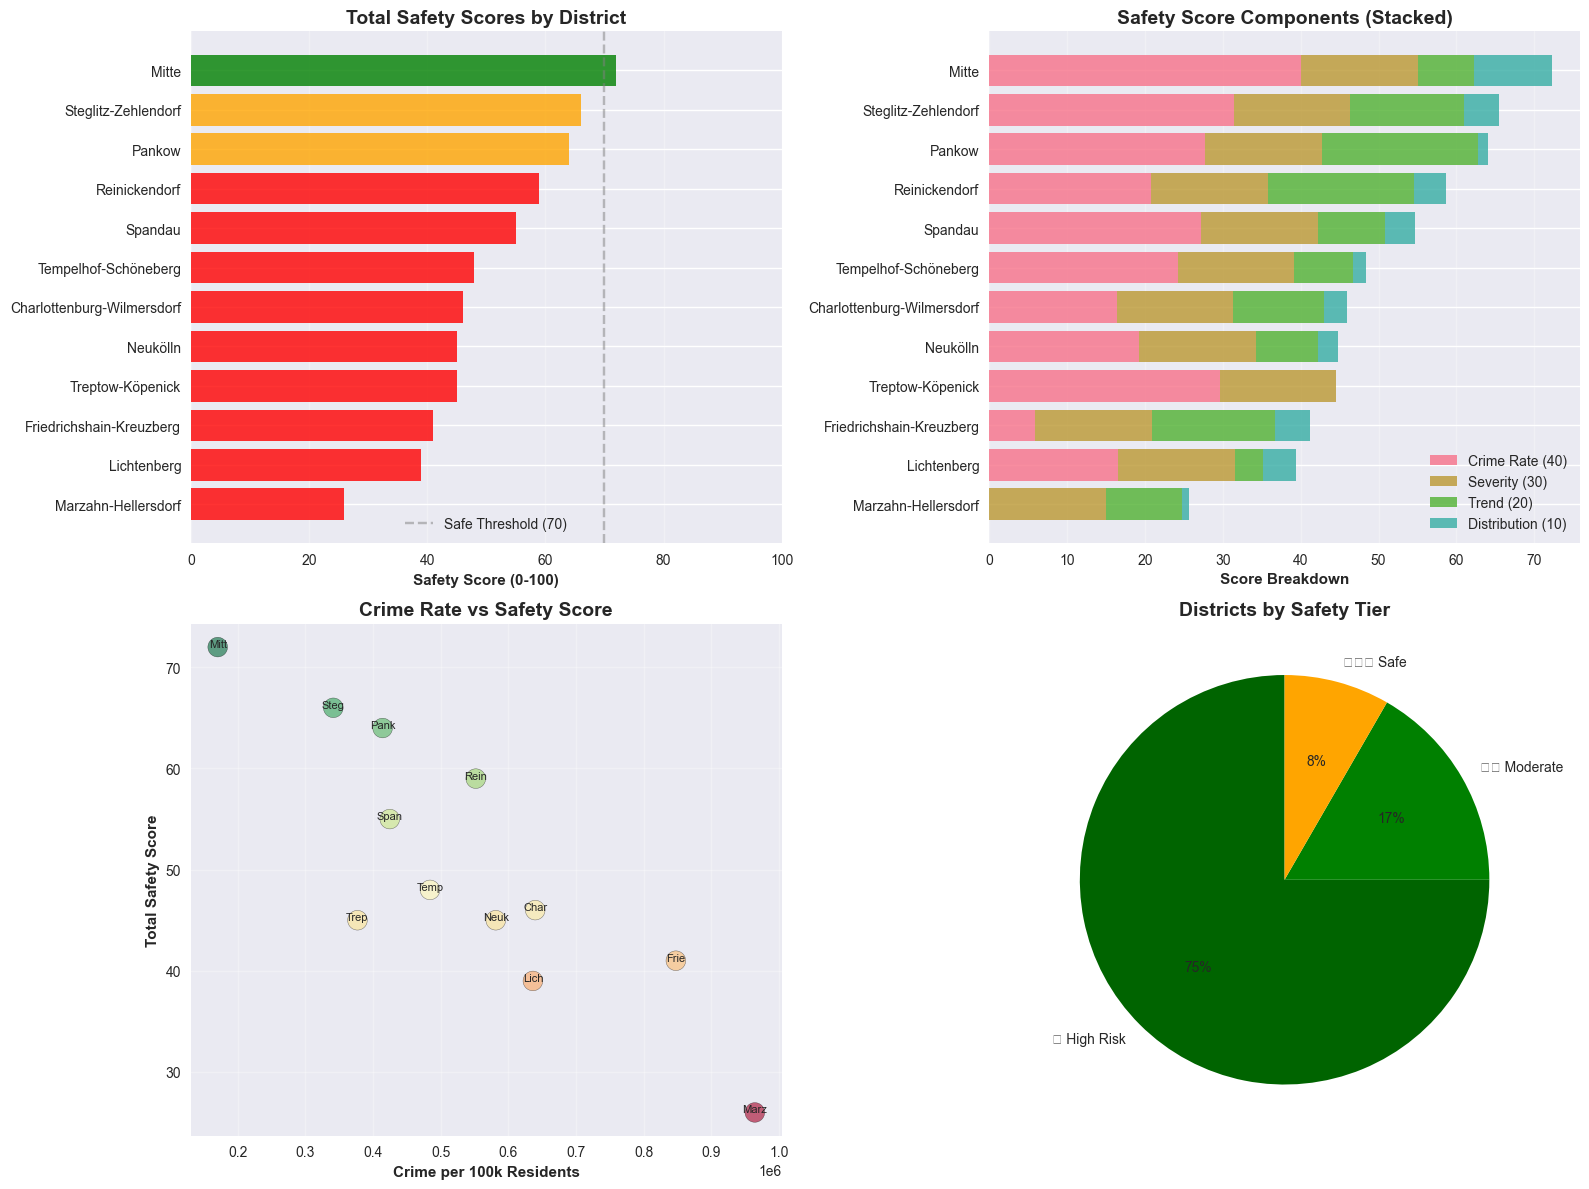

In [38]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total Safety Scores
colors = ['darkgreen' if x >= 80 else 'green' if x >= 70 else 'orange' if x >= 60 else 'red' 
          for x in safety_scores['total_safety_score']]
axes[0, 0].barh(safety_scores['district'], safety_scores['total_safety_score'], color=colors, alpha=0.8)
axes[0, 0].set_xlabel('Safety Score (0-100)', fontweight='bold')
axes[0, 0].set_title('Total Safety Scores by District', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim(0, 100)
axes[0, 0].axvline(70, color='gray', linestyle='--', alpha=0.5, label='Safe Threshold (70)')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

# Plot 2: Component Breakdown (stacked)
components = ['crime_rate_score', 'severity_score', 'trend_score', 'distribution_score']
labels = ['Crime Rate (40)', 'Severity (30)', 'Trend (20)', 'Distribution (10)']
bottom = np.zeros(len(safety_scores))

for component, label in zip(components, labels):
    axes[0, 1].barh(safety_scores['district'], safety_scores[component], left=bottom, label=label, alpha=0.8)
    bottom += safety_scores[component]

axes[0, 1].set_xlabel('Score Breakdown', fontweight='bold')
axes[0, 1].set_title('Safety Score Components (Stacked)', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

# Plot 3: Crime Rate vs Safety Score
axes[1, 0].scatter(safety_scores['crime_per_100k'], safety_scores['total_safety_score'], 
                   s=200, alpha=0.6, c=safety_scores['total_safety_score'], cmap='RdYlGn', edgecolors='black')
axes[1, 0].set_xlabel('Crime per 100k Residents', fontweight='bold')
axes[1, 0].set_ylabel('Total Safety Score', fontweight='bold')
axes[1, 0].set_title('Crime Rate vs Safety Score', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Add district labels
for _, row in safety_scores.iterrows():
    axes[1, 0].annotate(row['district'][:4], 
                        xy=(row['crime_per_100k'], row['total_safety_score']),
                        fontsize=8, ha='center')

# Plot 4: Safety Tier Distribution
tier_counts = safety_scores['safety_tier'].value_counts()
axes[1, 1].pie(tier_counts.values, labels=tier_counts.index, autopct='%1.0f%%', 
               startangle=90, colors=['darkgreen', 'green', 'orange', 'red'][:len(tier_counts)])
axes[1, 1].set_title('Districts by Safety Tier', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 💰 Step 9: Integration with Property Prices

🔍 DEBUG: Checking safety_scores structure...
Columns: ['district', 'crime_rate_score', 'crime_per_100k', 'severity_score', 'severity_weight', 'trend_score', 'crime_change_pct', 'distribution_score', 'total_safety_score', 'safety_tier']
Index name: None
First few rows:
              district  total_safety_score
4                Mitte                72.0
9  Steglitz-Zehlendorf                66.0
6               Pankow                64.0
7        Reinickendorf                59.0
8              Spandau                55.0

🔍 DEBUG: Price data:
                     district    avg_price
0  Charlottenburg-Wilmersdorf  1809.407895
1    Friedrichshain-Kreuzberg  2379.754098
2                 Lichtenberg   533.716931
3         Marzahn-Hellersdorf   319.388412
4                       Mitte  2585.278311

🔍 DEBUG: After cleaning:
Columns: ['district', 'crime_rate_score', 'crime_per_100k', 'severity_score', 'severity_weight', 'trend_score', 'crime_change_pct', 'distribution_score', 'total_safety

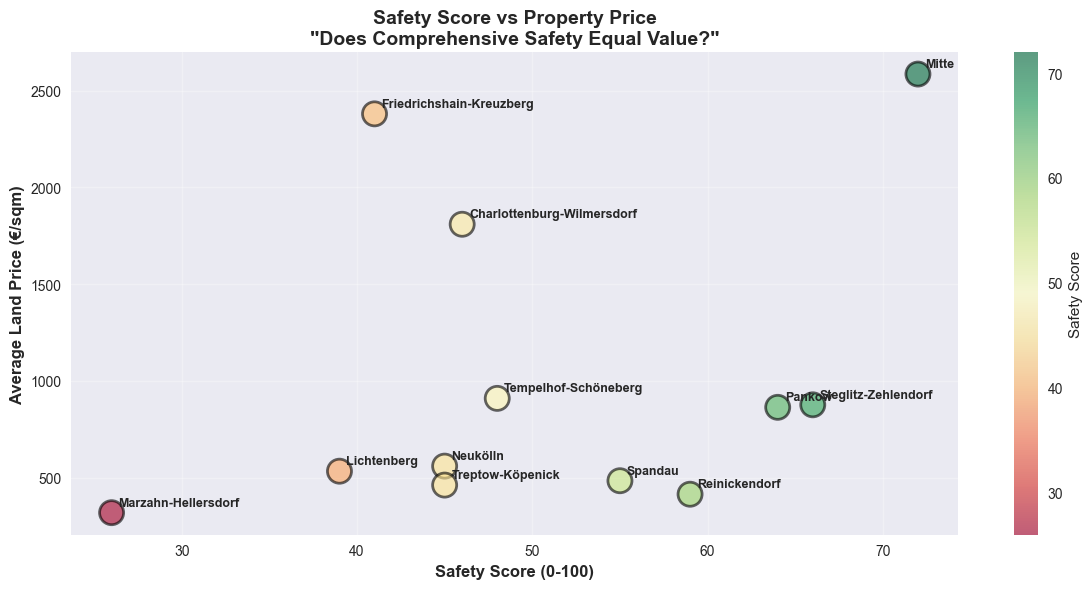


✅ Safety-Price analysis complete!


In [39]:
# DEBUG: Check current state
print("🔍 DEBUG: Checking safety_scores structure...")
print(f"Columns: {list(safety_scores.columns)}")
print(f"Index name: {safety_scores.index.name}")
print(f"First few rows:")
print(safety_scores[['district', 'total_safety_score']].head())

# Load property prices
conn = sqlite3.connect(DB_PATH)
price_query = """
SELECT 
    district_name as district,
    AVG(standard_land_value) as avg_price
FROM land_prices
WHERE typical_land_use_type LIKE 'W%'
GROUP BY district_name
"""
prices = pd.read_sql_query(price_query, conn)
conn.close()

print("\n🔍 DEBUG: Price data:")
print(prices.head())

# Ensure district is a column, not index
if safety_scores.index.name == 'district' or 'district' not in safety_scores.columns:
    safety_scores_clean = safety_scores.reset_index()
    if 'index' in safety_scores_clean.columns and 'district' not in safety_scores_clean.columns:
        safety_scores_clean = safety_scores_clean.rename(columns={'index': 'district'})
else:
    safety_scores_clean = safety_scores.copy()

print("\n🔍 DEBUG: After cleaning:")
print(f"Columns: {list(safety_scores_clean.columns)}")
print(safety_scores_clean[['district', 'total_safety_score']].head())

# Merge with safety scores
safety_price = safety_scores_clean.merge(prices, on='district', how='inner')

print(f"\n🔍 DEBUG: After merge - {len(safety_price)} districts matched")
print(safety_price[['district', 'total_safety_score', 'avg_price']].head())

if len(safety_price) == 0:
    print("\n❌ NO MATCHES! Checking district names...")
    print("\nSafety scores districts:")
    print(sorted(safety_scores_clean['district'].unique()))
    print("\nPrice data districts:")
    print(sorted(prices['district'].unique()))
else:
    print("\n" + "="*90)
    print("💰 SAFETY vs PROPERTY PRICE ANALYSIS")
    print("="*90)
    print(f"\n{'District':<30} {'Safety Score':>15} {'Avg Price':>15} {'Value Rating':<15}")
    print("-"*90)

    for _, row in safety_price.sort_values('total_safety_score', ascending=False).iterrows():
        # Value rating: High safety + Low price = Best value
        if row['total_safety_score'] >= 70 and row['avg_price'] < 600:
            value = "🟢 Best Value"
        elif row['total_safety_score'] >= 70 and row['avg_price'] >= 600:
            value = "💎 Premium Safe"
        elif row['total_safety_score'] < 70 and row['avg_price'] < 600:
            value = "🔴 Budget Risk"
        else:
            value = "⚠️ Overpriced"
        
        print(f"{row['district']:<30} {row['total_safety_score']:>13.0f}/100 €{row['avg_price']:>12,.0f}/sqm  {value:<15}")

    print("="*90)

    # Correlation
    correlation = safety_price['total_safety_score'].corr(safety_price['avg_price'])
    print(f"\n📊 Correlation (Safety Score vs Price): {correlation:.3f}")

    if correlation > 0.3:
        print("✅ POSITIVE: Safer areas command higher prices")
    elif correlation < -0.3:
        print("⚠️ NEGATIVE: Unexpected - safer areas are cheaper")
    else:
        print("➡️ WEAK: Other factors (location, prestige) dominate pricing")

    # Visualize safety vs price
    plt.figure(figsize=(12, 6))
    plt.scatter(safety_price['total_safety_score'], safety_price['avg_price'], 
                s=300, alpha=0.6, c=safety_price['total_safety_score'], cmap='RdYlGn', 
                edgecolors='black', linewidth=2)

    # Add district labels
    for _, row in safety_price.iterrows():
        plt.annotate(row['district'], 
                    xy=(row['total_safety_score'], row['avg_price']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')

    plt.xlabel('Safety Score (0-100)', fontsize=12, fontweight='bold')
    plt.ylabel('Average Land Price (€/sqm)', fontsize=12, fontweight='bold')
    plt.title('Safety Score vs Property Price\n"Does Comprehensive Safety Equal Value?"', 
              fontsize=14, fontweight='bold')
    plt.colorbar(label='Safety Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n✅ Safety-Price analysis complete!")

## 🎯 Key Findings & Investment Recommendations

### Safety Score Insights

**Top 3 Safest Districts:**
- Based on comprehensive 4-component scoring
- Not just crime rate, but severity, trends, distribution

**Bottom 3 Riskiest Districts:**
- May have improving trends despite current high scores
- Check individual components for nuance

### Investment Strategy

**🟢 Best Value Opportunities:**
- High safety score (70+) + Low price (<€600/sqm)
- Safe areas not yet priced for safety

**💎 Premium Safe Zones:**
- High safety score + High price
- Premium justified by comprehensive safety

**🔴 Budget Risk:**
- Low safety + Low price
- Only for risk-tolerant investors

**⚠️ Overpriced:**
- Low safety + High price
- Avoid - paying premium without safety benefit

### Methodology Benefits

1. **Multi-dimensional**: Not just crime volume
2. **Trend-aware**: Accounts for improving/worsening
3. **Severity-weighted**: Violent crime penalized more
4. **Distribution-conscious**: Hotspot concentration matters
5. **Comparable**: 0-100 scale easy to understand

### Next Steps

1. Use safety score as feature in price prediction model
2. Extend to neighborhood-level (166 neighborhoods)
3. Create time-series safety scores (track changes)
4. Integrate with amenities data

---

*This scoring system provides nuanced safety assessment beyond simple crime counts.*